In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import torch
from src.utils import obtain_all_ice_variants, evaluate, load_model_and_tokenizer
from src.partial_sums import extract_partial_sums, probe_partial_sums_logit_lens
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = 'EleutherAI/pythia-12b-deduped-v0'
DATASET_PATH = './data/pythia_12b_partial_sums_data.pt'

### Load the model and the dataset

*To analyze partial sums, we use a different dataset composed exclusively of addition examples. We also ensure that no partial sums overlap within any given equation.*

In [18]:
tokenizer, model = load_model_and_tokenizer(MODEL_NAME, device)
dataset = torch.load(DATASET_PATH)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model EleutherAI/pythia-12b-deduped-v0 into HookedTransformer


### Preprocess the dataset

In [20]:
dataset_no_ice, dataset_single_ice, _, _ = obtain_all_ice_variants(dataset)

### Evaluate the model on the dataset

In [25]:
results_no_ice, results_single_ice = [evaluate(tokenizer, model, data, batch_size=10, prepend_bos=True) for data in [dataset_no_ice, dataset_single_ice]]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

In [26]:
results = [results_no_ice, results_single_ice]
print("Results (No ICE, Single ICE, Two ICE, All ICE):", [np.round(np.mean(res), 3) for res in results])

Results (No ICE, Single ICE, Two ICE, All ICE): [0.269, 0.438]


### Extract partial sums from the dataset

In [34]:
partial_sums_ice, partial_sums_task_prompt = extract_partial_sums(dataset)
# Here we only have single ICE, so we extract the first element
partial_sums_ice = [item[0] for item in partial_sums_ice]

### Probe for partial sums with the logit lens

In [36]:
top_k = 1
partial_sums_probes_ice = probe_partial_sums_logit_lens(dataset_single_ice, partial_sums_ice, model, k=top_k, prepend_bos=True, include_ice=True)
partial_sums_probes_task_prompt = probe_partial_sums_logit_lens(dataset_single_ice, partial_sums_task_prompt, model, k=top_k, prepend_bos=True, include_ice=False)

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

### Plot results

In [38]:
xticks = model.to_str_tokens("a + b + c = d. x + y + z =", prepend_bos=True)
xticks[0] = '<bos>'

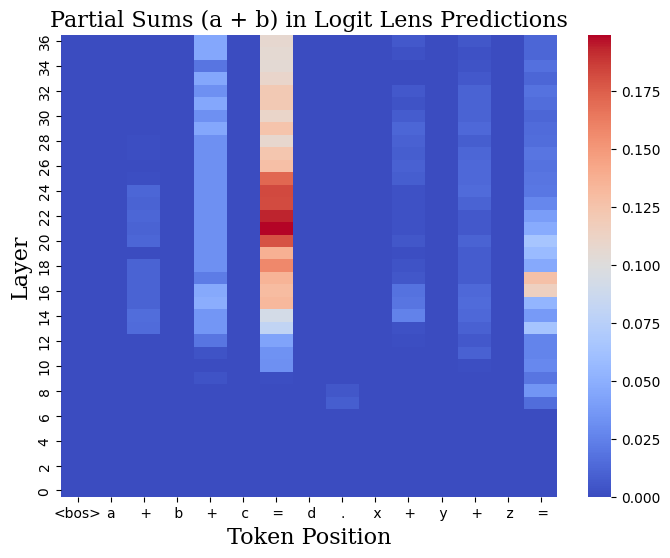

In [39]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(partial_sums_probes_ice.mean(dim=0)[0], cmap="coolwarm", fmt=".2f", xticklabels=xticks)
ax.invert_yaxis()
plt.title(f"Partial Sums (a + b) in Logit Lens Predictions", fontsize=16, fontname='DeJavu Serif')
plt.xlabel('Token Position', fontsize=16, fontname='DeJavu Serif')
plt.ylabel('Layer', fontsize=16, fontname='DeJavu Serif')
plt.show()

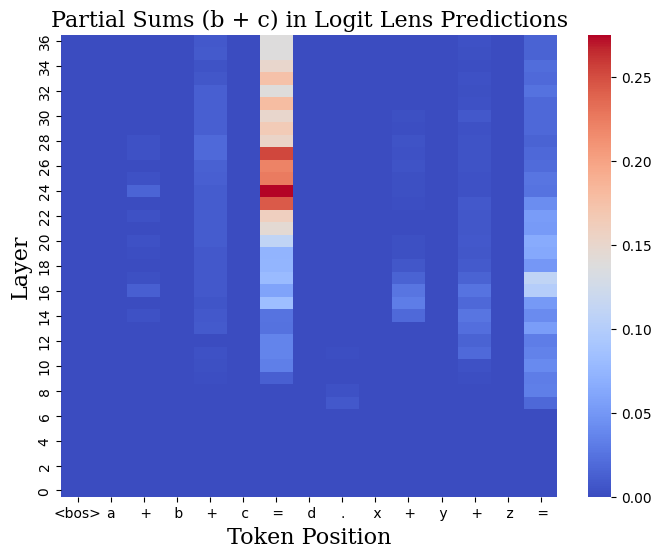

In [40]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(partial_sums_probes_ice.mean(dim=0)[1], cmap="coolwarm", fmt=".2f", xticklabels=xticks)
ax.invert_yaxis()
plt.title(f"Partial Sums (b + c) in Logit Lens Predictions", fontsize=16, fontname='DeJavu Serif')
plt.xlabel('Token Position', fontsize=16, fontname='DeJavu Serif')
plt.ylabel('Layer', fontsize=16, fontname='DeJavu Serif')
plt.show()

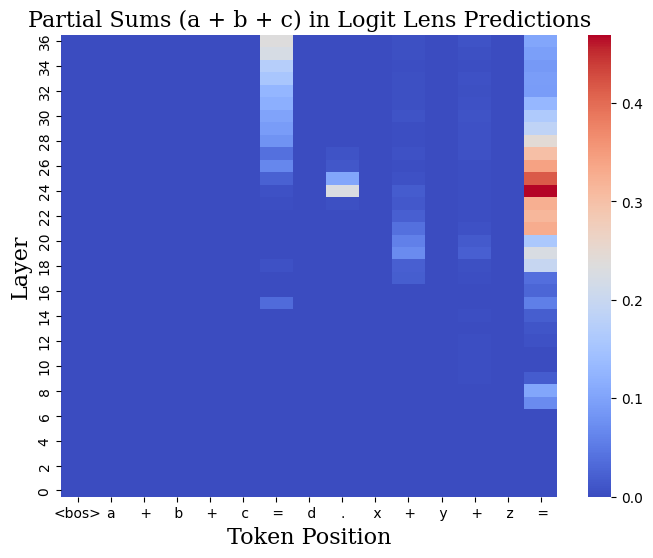

In [41]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(partial_sums_probes_ice.mean(dim=0)[2], cmap="coolwarm", fmt=".2f", xticklabels=xticks)
ax.invert_yaxis()
plt.title(f"Partial Sums (a + b + c) in Logit Lens Predictions", fontsize=16, fontname='DeJavu Serif')
plt.xlabel('Token Position', fontsize=16, fontname='DeJavu Serif')
plt.ylabel('Layer', fontsize=16, fontname='DeJavu Serif')
plt.show()